### Introduction 

This tutorial is an end-to-end walkthrough of training a Gradient Boosting model using decision trees with the tf.estimator API. Boosted Trees models are among the most popular and effective machine learning approaches for both regression and classification. It is an ensemble technique that combines the predictions from several (think 10s, 100s or even 1000s) tree models.

Boosted Trees models are popular with many machine learning practitioners as they can achieve impressive performance with minimal hyperparameter tuning.

In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
import pandas as pd
from IPython.display import clear_output


In [2]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [3]:
import tensorflow as tf
tf.random.set_seed(123)

In [4]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [6]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

In [7]:
dftrain.age.hist(bins=20)

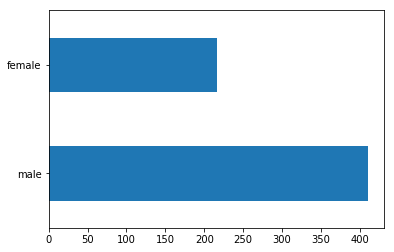

In [8]:
dftrain.sex.value_counts().plot(kind='barh')

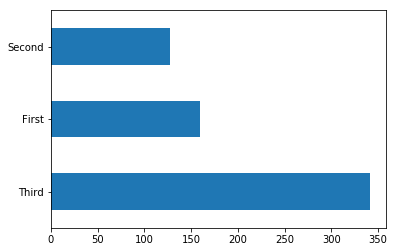

In [9]:
dftrain['class'].value_counts().plot(kind='barh')

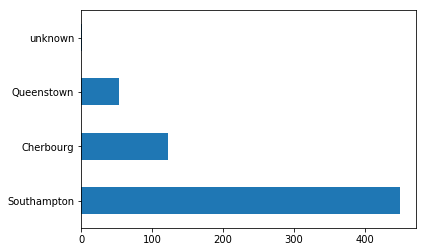

In [10]:
dftrain['embark_town'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

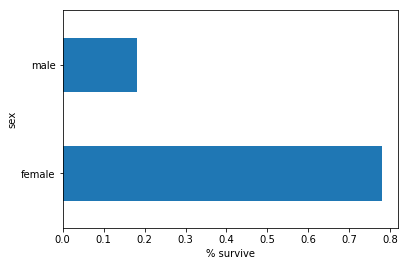

In [11]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [12]:
fc = tf.feature_column
CATEGORICAL_COLUMNS  = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [13]:
def one_hot_cat_column(feature_name, vocab):
    return tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocab))


feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
    # Encode one-hot 
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))


In [14]:
example = dict(dftrain.head(1))
class_fc = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('class', ('First', 'Second', 'Third')))


In [15]:
print('Feature value: "{}"'.format(example['class'].iloc[0]))
print('One-hot encoded: ', tf.keras.layers.DenseFeatures([class_fc])(example).numpy())

Feature value: "Third"


W0319 14:29:20.219007 140497170409280 deprecation.py:323] From /home/rohan/miniconda3/envs/deep_learning_tf/lib/python3.6/site-packages/tensorflow/python/ops/lookup_ops.py:1347: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0319 14:29:20.220978 140497170409280 deprecation.py:323] From /home/rohan/miniconda3/envs/deep_learning_tf/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4307: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0319 14:29:20.221535 140497170409280 deprecation.py:323] From /home/rohan/miniconda3/envs/deep_learning_tf/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4362: Vocabular

One-hot encoded:  [[0. 0. 1.]]


In [16]:
tf.keras.layers.DenseFeatures(feature_columns)(example).numpy()

W0319 14:29:20.231811 140497170409280 deprecation.py:323] From /home/rohan/miniconda3/envs/deep_learning_tf/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

In [17]:
# Use entire batch 
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
            
        # For traning, cycle thru dataset many times as need(n_epochs=None)
        dataset = dataset.repeat(n_epochs)
        # In memory taaining doesn't use batching
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

# Training and evaluation input functions
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [18]:
# Build, initialize, train, test model 
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model 

W0319 14:29:20.280024 140497170409280 estimator.py:1799] Using temporary folder as model directory: /tmp/tmp66j1wft_


In [19]:
linear_est.train(train_input_fn, max_steps=100)

W0319 14:29:20.295851 140497170409280 deprecation.py:323] From /home/rohan/miniconda3/envs/deep_learning_tf/lib/python3.6/site-packages/tensorflow/python/training/training_util.py:238: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
W0319 14:29:20.858706 140497170409280 deprecation.py:506] From /home/rohan/miniconda3/envs/deep_learning_tf/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py:187: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [20]:
# Evalution 
result = linear_est.evaluate(eval_input_fn)

W0319 14:29:24.207725 140497170409280 deprecation.py:323] From /home/rohan/miniconda3/envs/deep_learning_tf/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [21]:
clear_output()

In [22]:
print(pd.Series(result))

accuracy                  0.765152
accuracy_baseline         0.625000
auc                       0.832844
auc_precision_recall      0.789631
average_loss              0.478908
label/mean                0.375000
loss                      0.478908
precision                 0.703297
prediction/mean           0.350790
recall                    0.646465
global_step             100.000000
dtype: float64


In [23]:
# Fit entire batch in one-go for small data
n_batch = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns, n_batches_per_layer=n_batch)

W0319 14:29:24.922831 140497170409280 estimator.py:1799] Using temporary folder as model directory: /tmp/tmp1m334tgo


In [24]:
# The model will stop training once the specified number of trees is built, not 
# based on the number of steps.
est.train(train_input_fn, max_steps=10)



W0319 14:29:25.069164 140497170409280 deprecation.py:323] From /home/rohan/miniconda3/envs/deep_learning_tf/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column.py:2121: NumericColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0319 14:29:25.072164 140497170409280 deprecation.py:323] From /home/rohan/miniconda3/envs/deep_learning_tf/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column.py:2121: IndicatorColumn._transform_feature (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0319 14:29:25.072665 140497170409280 deprecation.py:323] From /home/roh

In [25]:
# Eval.
result = est.evaluate(eval_input_fn)
clear_output()
print(pd.Series(result))

accuracy                 0.803030
accuracy_baseline        0.625000
auc                      0.846954
auc_precision_recall     0.830350
average_loss             0.485635
label/mean               0.375000
loss                     0.485635
precision                0.758242
prediction/mean          0.427167
recall                   0.696970
global_step             10.000000
dtype: float64


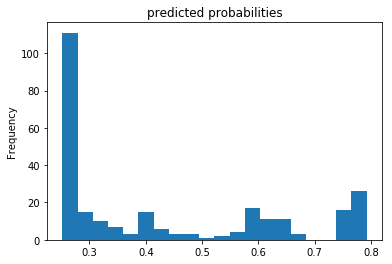

In [26]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities');

(0, 1.05)

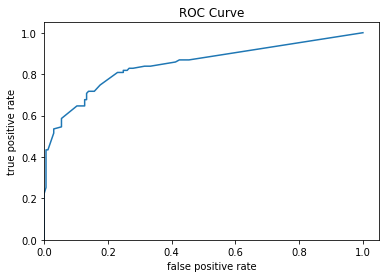

In [27]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt 

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0)
plt.ylim(0,)